# Adapting Infection Spread Model

### Modeling infection spread using SIR model

In [1]:
import numpy as np

def SIR_model(S0, I0, R0, beta, gamma, days):
    dtype = [('day', int), ('susceptible', float), ('infected', float), ('recovered', float)]
    #Initialize arrays
    data = np.zeros(days, dtype=dtype)
    data['day'] = np.arange(days)
    data['susceptible'][0] = S0
    data['infected'][0] = I0
    data['recovered'][0] = R0
    
    #Total population
    N = S0 + I0 + R0 

    #Calculate values
    for t in range(1, days):
        data['susceptible'][t] = data['susceptible'][t-1] - beta * data['susceptible'][t-1] * data['infected'][t-1] / N
        data['infected'][t] = data['infected'][t-1] + beta * data['susceptible'][t-1] * data['infected'][t-1] / N - gamma * data['infected'][t-1]
        data['recovered'][t] = data['recovered'][t-1] + gamma * data['infected'][t-1]

    return data

# --------------------------
# Main Program
# --------------------------

# Initial values
S0 = 990 #Number of susceptible individuals
I0 = 10 #Number of infected individuals
R0 = 0 #Number of recovered individuals
beta = 0.3 #infection rate
gamma = 0.1 #recovery rate
days = 160 #Number of days to simulate

SIR_data = SIR_model(S0, I0, R0, beta, gamma, days)

#print("\nSusceptible:\n", SIR_data['susceptible'])
#print("\nInfected:\n", SIR_data['infected'])
#print("\nRecovered:\n", SIR_data['recovered'])




Susceptible:
 [990.         987.03       983.48557527 979.26128106 974.23473982
 968.26496445 961.19099198 952.83109824 942.9829625  931.42526134
 917.92128145 902.22522732 884.09192192 863.2905002  839.62240472
 812.94343891 783.18877331 750.39866776 714.74143118 676.52912262
 636.22117742 594.41200712 551.80092648 509.14626388 467.20934516
 426.69692365 388.21139003 352.21630336 319.021037   288.78399423
 261.5303633  237.17862468 215.57005188 196.4967061  179.7251654
 165.0148463  152.13095477 140.85278474 130.97835575 122.32638738
 114.7364733  108.06813292 102.19923609  97.02414187  92.45177191
  88.40375202  84.81269512  81.62065913  78.7777887   76.24113497
  73.9736399   71.94326788  70.12226688  68.48654141  67.01512149
  65.6897132   64.49431827  63.41491196  62.43917003  61.55623699
  60.756529    60.03156603  59.37382856  58.77663499  58.23403648
  57.74072663  57.29196357  56.88350267  56.51153836  56.17265346
  55.86377521  55.58213685  55.32524401  55.09084524  54.87690

### Line Plots of SIR Model Dynamics

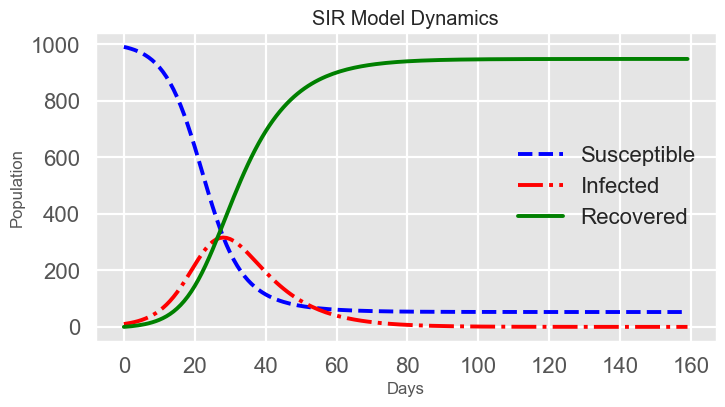

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')


plt.figure(figsize=(8,4))
plt.plot(SIR_data['day'], SIR_data['susceptible'], '--b', label='Susceptible')
plt.plot(SIR_data['day'], SIR_data['infected'], '-.', label='Infected', color='red')
plt.plot(SIR_data['day'], SIR_data['recovered'], label='Recovered', color='green')
plt.xlabel('Days')
plt.ylabel('Population')
plt.title('SIR Model Dynamics')
plt.legend();


### Scatter Plot of Final Infected Individuals from Monte Carlo Simulation